In [384]:
import os
import sys
import argparse
import datetime
import xarray as xr
import pyresample as pr
import numpy as np
from netCDF4 import Dataset

from pyproj import Transformer


In [385]:
def seconds_to_unix_time(seconds_since_1978):
    """Convert seconds since 1978-01-01 to Unix timestamp."""
    base_datetime = datetime.datetime(1978, 1, 1, 0, 0, 0)
    target_datetime = base_datetime + datetime.timedelta(seconds=seconds_since_1978)
    return target_datetime.timestamp()


In [398]:
import numpy as np  
import xarray as xr

def normalize_domain(lat_min, lat_max, lon_min, lon_max):  
    # Step 1: Ensure latitude bounds are valid  
    lat_min = np.clip(lat_min, 0, 90)  
    lat_max = np.clip(lat_max, 0, 90)  

    # Step 2: Normalize longitude values to -180 to 180 range  
    def normalize_longitude(lon):  
        lon = lon % 360  
        if lon > 180:  
            lon -= 360  
        return lon  

    lon_min = normalize_longitude(lon_min)  
    lon_max = normalize_longitude(lon_max)  

    # Step 3: Handle crossing the -180/180 boundary  
    if lon_min > lon_max:  
        # Domain crosses the dateline  
        return {  
            'lat_min': min(lat_min, lat_max),  
            'lat_max': max(lat_min, lat_max),  
            'lon_ranges': [  
                (-180, lon_max),  
                (lon_min, 180)  
            ]  
        }  
    else:  
        # Normal case  
        return {  
            'lat_min': min(lat_min, lat_max),  
            'lat_max': max(lat_min, lat_max),  
            'lon_ranges': [(lon_min, lon_max)]  
        }  

# Example usage  
def select_domain(global_data, domain_info):  
    """  
    global_data: Your grid data  
    domain_info: Output from normalize_domain  
    """  
    lat_mask = (global_data['lat'] >= domain_info['lat_min']) & (global_data['lat'] <= domain_info['lat_max'])  

    lon_mask = np.zeros_like(global_data['lon'], dtype=bool)  
    for lon_range in domain_info['lon_ranges']:  
        lon_mask |= (global_data['lon'] >= lon_range[0]) & (global_data['lon'] <= lon_range[1])  

    return lat_mask & lon_mask  


# Your example  
#domain = normalize_domain(55.9, 86.0, -109.7, 37.7)  
#print(domain)  
#print("--------------")
# Test crossing dateline  
#print("Normalized domain")
#crossing_domain = normalize_domain(55.9, 86.0, 170, -170)  
#print(crossing_domain)  

#input_file = "../../sample_data/Cryo_clim/reg_ll_prob_snow_c_date.nc"
#nc = xr.open_dataset(input_file)
#mask = select_domain(nc, crossing_domain)
#print(mask)


In [423]:
def get_geom_def(
    input_file, output_file, harmonie_file, obs_var="prob_snow_c", var_out="prob_snow_c", model_var="fscov", prob_snow_thr=80.0
):
    # Open input datasets
    nc = xr.open_dataset(input_file)
    ds_harm = xr.open_dataset(harmonie_file)

    # Create source definition (HARMONIE grid)
    harm_lat = ds_harm["latitude"].values
    harm_lon = ds_harm["longitude"].values
    harm_lon, harm_lat = np.meshgrid(harm_lon, harm_lat)
    #src_def = pr.geometry.GridDefinition(lons=harm_lon, lats=harm_lat)
    src_def = pr.geometry.SwathDefinition(lons=harm_lon, lats=harm_lat)

    # Get the domain bounds from HARMONIE
    lat_min = harm_lat.min()
    lat_max = harm_lat.max()
    lon_min = harm_lon.min()
    lon_max = harm_lon.max() #+ 50 # increase range artificially
    print("Borders of the harmonie grid")
    print(lat_min,lat_max)
    print(lon_min,lon_max)
    # Create target definition (subset of NetCDF grid)
    # Get the 2D lat/lon arrays from the NetCDF file
    nc_lat = nc.lat.values  # This is already 2D
    nc_lon = nc.lon.values  # This is already 2D

    #corrected_lons = (((nc.lon.values + 180) % 360) - 180)  #((nc.lon.values + 180) % 360) - 180)
    #print("Original lons")
    #print(nc_lon)
    #print("Corrected lons")
    #print(corrected_lons)
    #filter undefined values
    nc_lat_filt = nc.lat.where((nc.lat >= 0) & (nc.lat <= 90))
    nc_lon_filt = nc.lon.where((nc.lon >= -180) & (nc.lon <= 180))

    #nc_lon = corrected_lons
    orig_def = pr.geometry.GridDefinition(lons = nc_lon, lats = nc_lat)
    

    # Create mask for points within HARMONIE domain
    domain_mask = (nc_lat >= lat_min) & (nc_lat <= lat_max) & \
                  (nc_lon >= lon_min) & (nc_lon <= lon_max)
    
    domain = normalize_domain(nc.lat.min().values.item(),nc.lat.max().values.item(),nc.lon.min().values.item(),nc.lon.max().values.item()) 
    print(domain["lon_ranges"])
    #crossing_domain = normalize_domain(lat_min,
    #domain_mask = select_domain(nc,domain)
    # Get the corresponding x and y indices where the mask is True
    y_indices, x_indices = np.where(domain_mask)

    # Get the unique x and y coordinates that fall within our domain
    unique_x = np.unique(nc.x.values[x_indices])
    unique_y = np.unique(nc.y.values[y_indices])

    # Create the target grid definition using the masked coordinates
    x_grid, y_grid = np.meshgrid(unique_x, unique_y)

    # Get corresponding lat/lon for these points
    target_lat = nc_lat[np.ix_(range(len(unique_y)), range(len(unique_x)))]
    target_lon = nc_lon[np.ix_(range(len(unique_y)), range(len(unique_x)))]
    #print(unique_x)
    #print(unique_x.shape)

    #print(type(target_lat))
    #print(type(harm_lat))

    # Create transformer from LAEA to WGS84
    #transformer = Transformer.from_proj(
    #"+proj=laea +ellps=WGS84 +lat_0=90 +lon_0=0",  # Source projection from file
    #"+proj=longlat +ellps=WGS84 +datum=WGS84",     # Target projection (regular lat-lon)
    #always_xy=True
    #)

    # Get the source x and y coordinates
    # Get the source x and y coordinates (already 2D)
    #X = nc.xc.values
    #Y = nc.yc.values

    # Transform source grid coordinates to lat/lon
    #source_lons, source_lats = transformer.transform(X, Y)

    # Create the target grid definition using the masked coordinates
    #x_grid, y_grid = np.meshgrid(source_lons,source_lats)

   
    # Create target definition
    target_def = pr.geometry.GridDefinition(lons=target_lon, lats=target_lat)
    #target_def = pr.geometry.GridDefinition(lons=x_grid, lats=y_grid)
    # Get the arrays
    lons = target_def.lons.copy()  # Make a copy to avoid modifying the original
    lats = target_def.lats.copy()

    # Define the threshold value
    threshold = 1e36

    # Replace values greater than threshold with NaN
    lons[lons > threshold] = np.nan
    lats[lats > threshold] = np.nan

    #     Create a new GridDefinition with the modified arrays
    from pyresample import geometry
    new_grid = geometry.GridDefinition(lons=lons, lats=lats)
    #print(f"lat and lon dimensions")
    #print(target_lat.shape)    
    #print(target_lon.shape)
    print("Borders of the resulging mesh")
    print(unique_y.min(),unique_y.max())
    print(unique_x.min(),unique_x.max())
    flip_y = np.flip(unique_y) #for some reason this is inverted!!
    corrected_lons = (((unique_x + 180) % 360) - 180)
    print(corrected_lons)
    return src_def, target_def, orig_def, flip_y, unique_x


In [424]:
input_file = "../../sample_data/Cryo_clim/reg_ll_prob_snow_c_date.nc"

nc = xr.open_dataset(input_file)

In [425]:
output_file ="test.nc"
#harmonie_file = "../../sample_data/CARRA1/snowc_2015-01-01_carra_west.grib2"
harmonie_file="../../sample_data/CARRA1/260289_20150501_analysis_reg.grib2"

obs_var = "prob_snow_c"
var_out = "fscov"
model_var = "fscov"
prob_snow_thr = 0.8

#data_out, bin_data, target_def = upsample_snowcover_carra_to_metgrid(
#        input_file, output_file, harmonie_file, obs_var, var_out, model_var,prob_snow_thr
#    )
src_def,target_def, orig_def, target_lat, target_lon = get_geom_def(
        input_file, output_file, harmonie_file, obs_var, var_out, model_var,prob_snow_thr
    )


Borders of the harmonie grid
55.9 86.0
-109.69999999999999 37.7
[(-179.9263153076172, 120.0)]
Borders of the resulging mesh
55.92499999999999 85.975
-179.92499999999998 37.67500000000001
[-179.925 -179.875 -179.825 ...   37.575   37.625   37.675]


In [402]:
target_lon.max()

37.67500000000001

In [403]:
target_lat.shape

(602,)

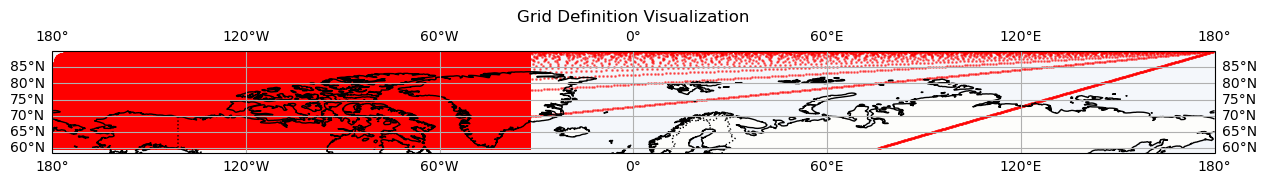

In [404]:
import pyresample as pr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Assuming you already have target_def defined
# target_def = pr.geometry.GridDefinition(lons=target_lon, lats=target_lat)

def plot_grid_definition(grid_def):
    # Get the lons and lats from the grid definition
    lons = grid_def.lons
    lats = grid_def.lats

    # Create a new figure with a map projection
    plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree()) 
    #ax = plt.axes(projection=ccrs.PlateCarree())
    # ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(
    # central_longitude=0.0,
    # central_latitude=90.0
    #))

    # Add coastlines and other features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.1)
    ax.add_feature(cfeature.OCEAN, alpha=0.1)

    # Plot the grid points
    plt.scatter(lons, lats, c='red', s=1, alpha=0.5, transform=ccrs.PlateCarree())

    # Set the map extent based on the grid boundaries
    lon_min, lon_max = np.nanmin(lons), np.nanmax(lons)
    lat_min, lat_max = np.nanmin(lats), np.nanmax(lats)
    #ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Add gridlines
    ax.gridlines(draw_labels=True)

    plt.title('Grid Definition Visualization')
    plt.show()

# Visualize the grid
plot_grid_definition(target_def)

# Created/Modified files during execution:
# No files created - plot displayed directly

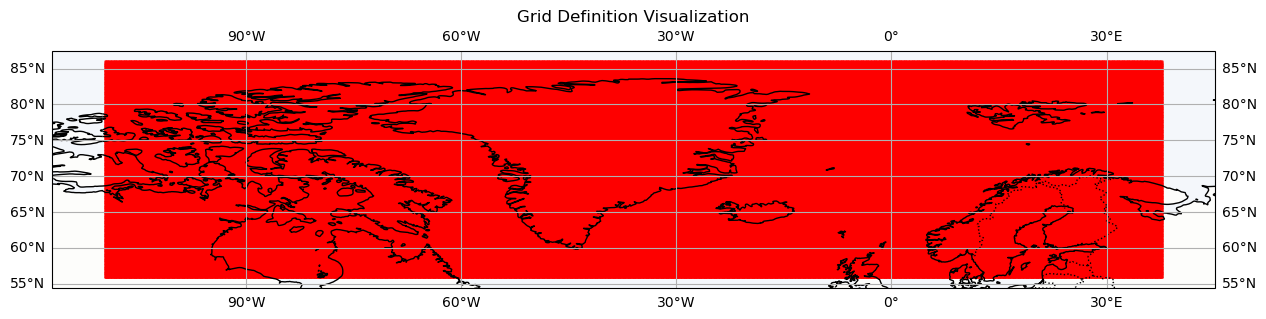

In [405]:
plot_grid_definition(src_def)


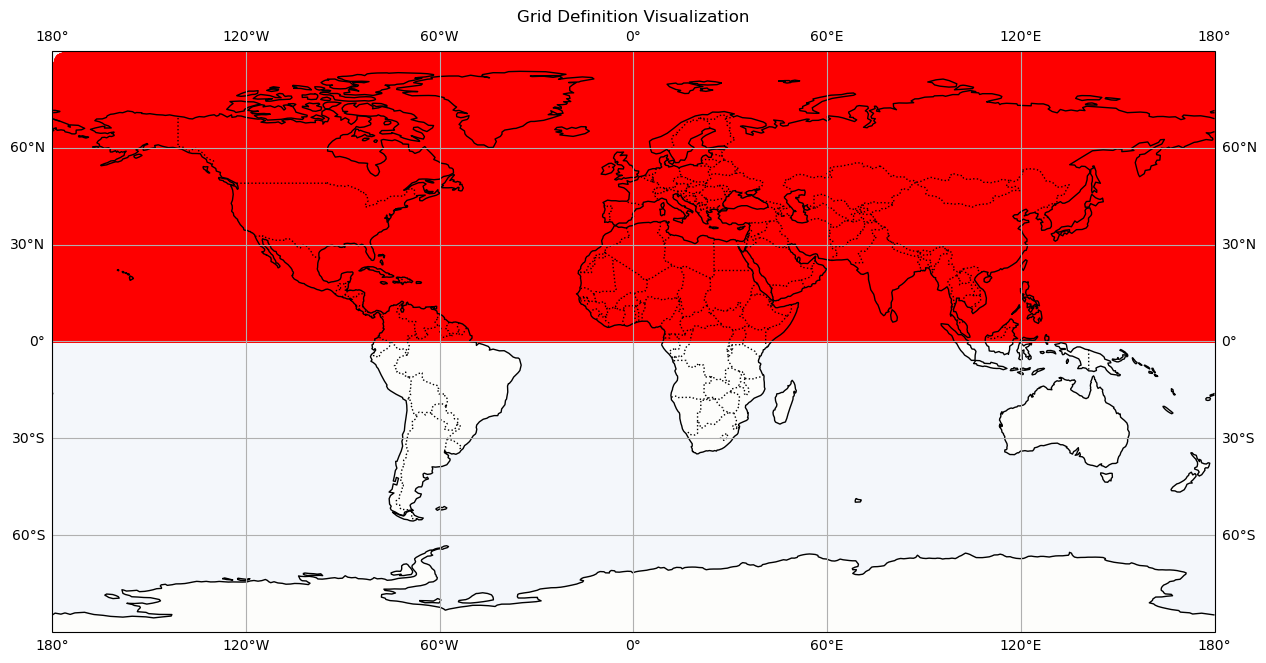

In [393]:
plot_grid_definition(orig_def)


In [338]:
def upsample_snowcover_carra_to_metgrid(
    input_file, output_file, harmonie_file, obs_var="prob_snow_c", var_out="prob_snow_c", model_var="fscov", prob_snow_thr=80.0
):
    # Open input datasets
    nc = xr.open_dataset(input_file)
    ds_harm = xr.open_dataset(harmonie_file)

    
    src_def,target_def, orig_def, target_lat, target_lon = get_geom_def(input_file, output_file, harmonie_file, obs_var, var_out, model_var, prob_snow_thr)

    # Resample data
    data_in = ds_harm[model_var].values
    bin_data_in = np.where((~np.isnan(data_in)) & (data_in > prob_snow_thr), 1, 0)
    times = ds_harm["time"].values
    # Using average resampling for downscaling
    data_out = pr.kd_tree.resample_nearest(
        src_def,
        #bin_data_in, #usig this I get a NaN error
        data_in,
        target_def,
        radius_of_influence=50000, #this is the default value!
        #sigmas=25000,
        fill_value=np.nan
    )
    #bin_data_out = pr.kd_tree.resample_nearest(
    #    src_def,
    #    bin_data_in,
    #    target_def,
    #   radius_of_influence=50000,
    #    #sigmas=25000, #only for gaussian type
    #    fill_value=np.nan
    #)
    # Process time values
    reference_date = np.datetime64("1978-01-01T00:00:00.0000")
    times = np.atleast_1d(times)
    seconds_since_1978 = [(t - reference_date) / np.timedelta64(1, "s") for t in times]
    std_unix_time = [seconds_to_unix_time(ts) for ts in seconds_since_1978]

    # Reshape data for output
    n_time = len(times)
    if len(data_out.shape) == 2:
        data_out = data_out.reshape(1, *data_out.shape)

    # Create binary snow cover data
    bin_data = np.where((~np.isnan(data_out)) & (data_out > prob_snow_thr), 1, 0)
    #print(bin_data.shape)
    #print(ds_harm["latitude"].shape)
    #print("harm shape")
    #print(ds_harm["longitude"].shape)
    #print(nc.lat.shape)
    ##print(ds_harm["latitude"].values)
    #print("target shape")
    #print(target_lat.shape)
    #print(data_out.shape)
    #unique_lats = np.sort(np.unique(target_lat))  
    #unique_lons = np.sort(np.unique(target_lon))
    #print(len(unique_lats))
    #unique_lons = 
        # Create output dataset
    ds = xr.Dataset(
        {
            var_out: (["time", "lat", "lon"], data_out),
            "bin_snow": (["time", "lat", "lon"], bin_data),
        },
        coords={
            "time": std_unix_time,
            "lat": target_lat,
            "lon": target_lon,
            #"lat": ds_harm["latitude"].values,
            #"lon": ds_harm["longitude"].values,
        },
    )


    return data_out, ds

In [339]:
data_out,ds = upsample_snowcover_carra_to_metgrid(
       input_file, output_file, harmonie_file, obs_var, var_out, model_var,prob_snow_thr
    )

Borders of the harmonie grid
55.9 86.0
-109.69999999999999 87.7
Borders of the resulging mesh
55.92499999999999 85.975
-179.975 87.67500000000004
[-179.975 -179.925 -179.875 ...   87.575   87.625   87.675]


In [321]:
def dump_to_nc(ds,output_file):
    
    # Set attributes
    ds.time.attrs.update(
        {
            "units": "seconds since 1970-01-01 00:00:00",
            "long_name": "reference time of product",
        }
    )
    ds.lon.attrs["units"] = "degrees_east"
    ds.lat.attrs["units"] = "degrees_north"
    ds[var_out].attrs["units"] = "None"
    ds["bin_snow"].attrs.update(
        {"units": "None", "coordinates": "lat lon", "grid_mapping": "longlat"}
    )

    # Set grid mapping attributes
    # Set attributes
    ds.time.attrs.update(
        {
            "units": "seconds since 1970-01-01 00:00:00",
            "long_name": "reference time of product",
        }
    )
    ds.lon.attrs["units"] = "degrees_east"
    ds.lat.attrs["units"] = "degrees_north"
    ds[var_out].attrs["units"] = "None"
    ds["bin_snow"].attrs.update(
        {"units": "None", "coordinates": "lat lon", "grid_mapping": "longlat",
         "proj4": "+proj=longlat +datum=WGS84"}
    )
    # Save to NetCDF
    ds.to_netcdf(output_file)

    # Add projection information
    with Dataset(output_file, "a", format="NETCDF4") as fid:
        proj_var = fid.createVariable("projection_regular_ll", "i4", ())
        proj_var.grid_mapping_name = "longlat"
        proj_var.false_northing = 0.0
        proj_var.earth_shape = "spherical"
        proj_var.proj4 = "+proj=longlat +datum=WGS84"

    # Set grid mapping attributes


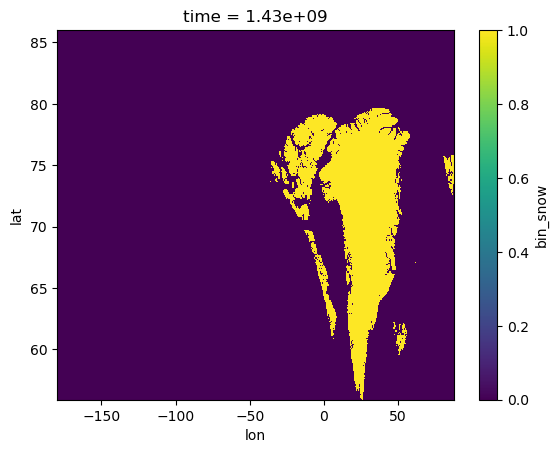

In [322]:
ds["bin_snow"].plot()

In [323]:
ds

<xarray.Dataset>
Dimensions:   (time: 1, lat: 602, lon: 3958)
Coordinates:
  * time      (time) float64 1.43e+09
  * lat       (lat) float64 85.97 85.92 85.88 85.82 ... 56.07 56.02 55.97 55.92
  * lon       (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 87.58 87.63 87.68
Data variables:
    fscov     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    bin_snow  (time, lat, lon) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

In [324]:
# Sort latitude coordinates in ascending order  
sorted_lat = sorted(ds.lat.values)  

# Reindex the dataset with sorted latitude  
array_fixed = ds.reindex(lat=sorted_lat)  

# Alternatively, you can use sortby which is more concise  
array_fixed = ds.sortby('lat')  

In [325]:
ds.reindex(lat=sorted_lat)  

<xarray.Dataset>
Dimensions:   (time: 1, lat: 602, lon: 3958)
Coordinates:
  * time      (time) float64 1.43e+09
  * lat       (lat) float64 55.92 55.97 56.02 56.07 ... 85.82 85.88 85.92 85.97
  * lon       (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 87.58 87.63 87.68
Data variables:
    fscov     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    bin_snow  (time, lat, lon) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

In [326]:
flip_lat = np.flip(ds.lat)  

In [327]:
flip_lat

<xarray.DataArray 'lat' (lat: 602)>
array([55.925, 55.975, 56.025, ..., 85.875, 85.925, 85.975])
Coordinates:
  * lat      (lat) float64 55.92 55.97 56.02 56.07 ... 85.82 85.88 85.92 85.97

In [340]:
dump_to_nc(ds,"snow_cover_from_carra_upsampled_to_met_grid.nc")

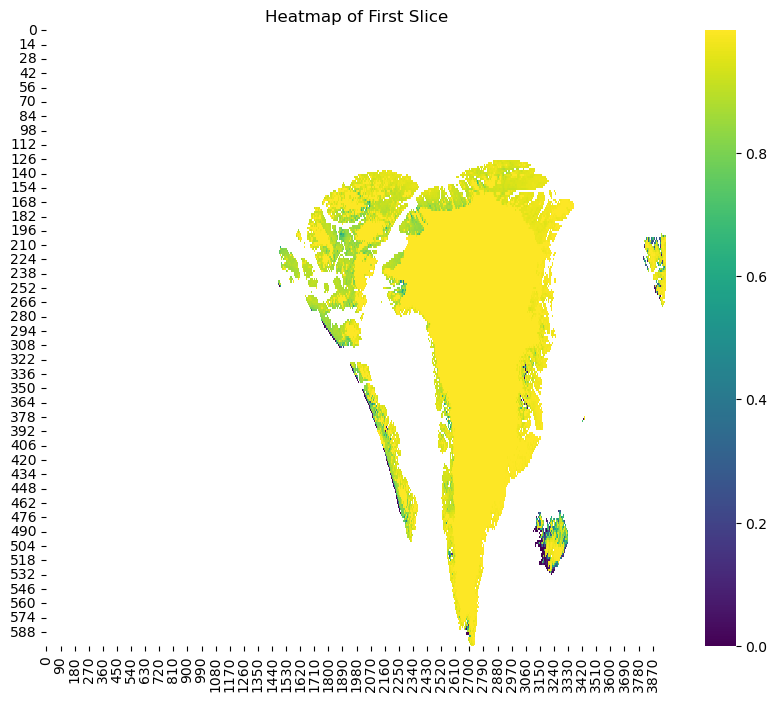

In [341]:
# Heatmap of first slice
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(data_out[0], cmap='viridis', mask=np.isnan(data_out[0]))
plt.title('Heatmap of First Slice')
plt.show()

# Method 2: 2D line plot of first row
#plt.figure(figsize=(10, 6))
#plt.plot(data_out[0, 0, :], 'b-', label='First row')
#plt.title('Line Plot of First Row')
#plt.xlabel('Index')
#plt.ylabel('Value')
#plt.legend()
#plt.show()


In [342]:
# original data set
ds_harm = xr.open_dataset(harmonie_file)

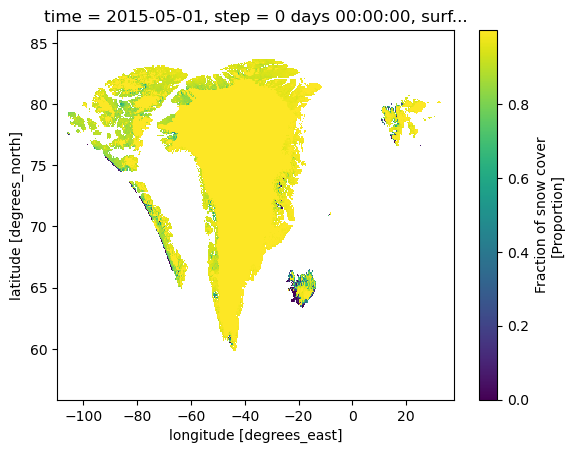

In [351]:
ds_harm["fscov"].plot()

In [352]:
ds_harm["longitude"].min()

<xarray.DataArray 'longitude' ()>
array(-109.7)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    valid_time  datetime64[ns] ...

In [353]:
ds_harm["longitude"].max()

<xarray.DataArray 'longitude' ()>
array(37.7)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    valid_time  datetime64[ns] ...

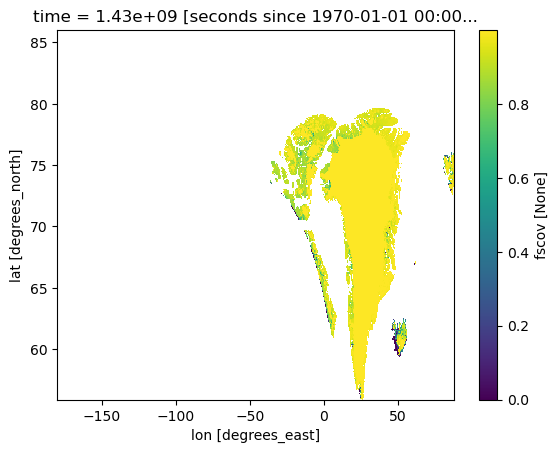

In [350]:
ds["fscov"].plot()

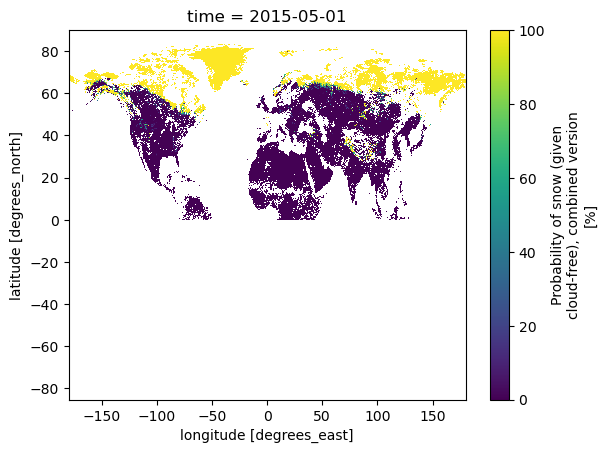

In [394]:
nc["prob_snow_c"].plot()

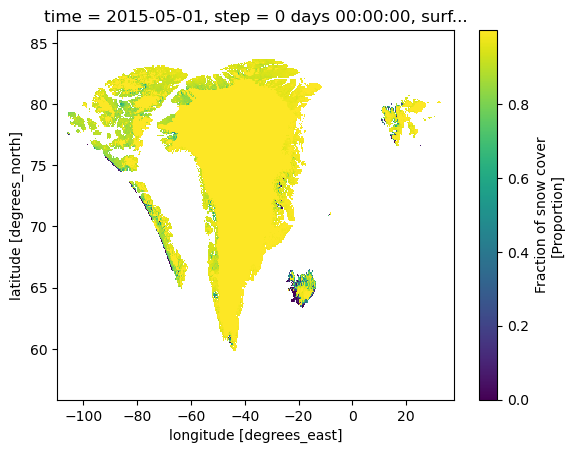

In [395]:
ds_harm["fscov"].plot()

In [397]:
nc["lat"].max()

<xarray.DataArray 'lat' ()>
array(9.96921e+36, dtype=float32)

In [416]:
nc.lat.min().values.item()

0.02483050897717476